# Visual Odometry Pipeline

* `Importing Libraries`

In [35]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from scipy.optimize import least_squares

DATADIR = os.path.join(os.getcwd(), "data")
CALIBDIR = os.path.join(os.getcwd(), "calibration", "calib_data")

* `Load Calibration data`

In [28]:
# === Load camera calibration ===
calib = np.load(os.path.join(CALIBDIR, "MultiMatrix.npz"))
K = calib['camMatrix']          # Intrinsic matrix
dist = calib['distCoef']    # Distortion coefficients

print("loaded calibration data successfully")

print("Camera Intrinsics (K):\n", K)
print("Distortion Coefficients:\n", dist)

loaded calibration data successfully
Camera Intrinsics (K):
 [[1.18516243e+03 0.00000000e+00 5.37934227e+02]
 [0.00000000e+00 1.21709038e+03 7.84347318e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [[ 0.05643447 -0.22052398  0.00293713 -0.00673012  0.20358823]]


* `Extract Frames from Video`

In [29]:
# === Parameters ===
video_path = os.path.join(DATADIR, 'vo_vid_2.mp4')  # Change this to your actual video path
save_every_n = 10  # Save every 5th frame
frame_dir = os.path.join(DATADIR, "frames_2")

os.makedirs(frame_dir, exist_ok=True)

# === Open video ===
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("❌ Could not open video.")
    exit()

frame_idx = 0
saved_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame (optional)
    frame = cv2.resize(frame, (640, 480))

    # Undistort and convert to grayscale
    undistorted = cv2.undistort(frame, K, dist)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

    # Save every Nth frame
    if frame_idx % save_every_n == 0:
        filename = os.path.join(frame_dir, f"frame_{frame_idx:04d}.png")
        cv2.imwrite(filename, gray)
        saved_count += 1

    frame_idx += 1

cap.release()
print(f"✅ Done. Saved {saved_count} frames to '{frame_dir}\'")

✅ Done. Saved 295 frames to 'c:\Users\YUSSEF\OneDrive\Desktop\Projects\Computer Vision\VisualOdometry\data\frames_2'


# Create Visual odometry class

In [32]:
class VisualOdometry():
    def __init__(self, data_dir, calib_dir):
        self.K = self._load_calib(os.path.join(calib_dir, "MultiMatrix.npz"))
        self.P = self.K @ np.hstack((np.eye(3), np.zeros((3, 1))))
        self.images = self._load_images(os.path.join(data_dir,"frames_2"))
        self.orb = cv2.ORB_create(3000)
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

    @staticmethod
    def _load_calib(filepath):
        """
        Loads the calibration of the camera
        Parameters
        ----------
        filepath (str): The file path to the camera file

        Returns
        -------
        K (ndarray): Intrinsic parameters
        dist (ndarray): Distortion coefficients
        """
        try:
            calib = np.load(filepath)
            K = calib['camMatrix']          # Intrinsic matrix
            # dist = calib['distCoef']    # Distortion coefficients
            print("loaded calibration data successfully")
            return K
        except Exception as e:
            raise RuntimeError(f"Failed to load calibration file: {e}")

    @staticmethod
    def _load_images(filepath):
        """
        Loads the images

        Parameters
        ----------
        filepath (str): The file path to image dir

        Returns
        -------
        images (list): grayscale images
        """
        try:
            image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath)) 
                          if file.endswith(('.png', '.jpg', '.jpeg'))]
            images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
            if not images or any(img is None for img in images):
                raise ValueError("Failed to load one or more images")
            return images[:125]
        except Exception as e:
            raise RuntimeError(f"Failed to load images: {e}")

    @staticmethod
    def _form_transf(R, t):
        """
        Makes a transformation matrix from the given rotation matrix and translation vector

        Parameters
        ----------
        R (ndarray): The rotation matrix
        t (list): The translation vector

        Returns
        -------
        T (ndarray): The transformation matrix
        """
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

    def get_matches(self, i, min_matches=10, visualize=False):
        """
        This function detect and compute keypoints and descriptors from the i-1'th and i'th image using the class orb object

        Parameters
        ----------
        i (int): The current frame

        Returns
        -------
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image
        """
        kp1, des1 = self.orb.detectAndCompute(self.images[i - 1], None)
        kp2, des2 = self.orb.detectAndCompute(self.images[i], None)
        
        if des1 is None or des2 is None:
            return None, None  # No features detected
        
        matches = self.flann.knnMatch(des1, des2, k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.8 * n.distance:
                good.append(m)
        
        if len(good) < min_matches:
            return None, None  # Insufficient matches
        
        if visualize:
            draw_params = dict(matchColor=-1, singlePointColor=None, matchesMask=None, flags=2)
            img3 = cv2.drawMatches(self.images[i], kp1, self.images[i-1], kp2, good, None, **draw_params)
            cv2.imshow("image", img3)
            cv2.waitKey(200)
        
        q1 = np.float32([kp1[m.queryIdx].pt for m in good])
        q2 = np.float32([kp2[m.trainIdx].pt for m in good])
        return q1, q2

    def get_pose(self, q1, q2):
        """
        Calculates the transformation matrix

        Parameters
        ----------
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix
        """
        if q1 is None or q2 is None:
            return None  # Skip pose estimation
    
        E, mask = cv2.findEssentialMat(q1, q2, self.K, method=cv2.RANSAC, prob=0.999, threshold=0.5)
        if E is None:
            return None
        
        # Check if essential matrix is valid (rank 2)
        u, s, vt = np.linalg.svd(E)
        if abs(s[0] - s[1]) > 0.1 or s[2] > 0.01:
            return None  # Degenerate essential matrix
    
        R, t = self.decomp_essential_mat(E, q1, q2)
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        return transformation_matrix

    def decomp_essential_mat(self, E, q1, q2):
        """
        Decompose the Essential matrix

        Parameters
        ----------
        E (ndarray): Essential matrix
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        right_pair (list): Contains the rotation matrix and translation vector
        """
        def sum_z_cal_relative_scale(R, t):
            # Get the transformation matrix
            T = self._form_transf(R, t)
            # Make the projection matrix
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            # Triangulate the 3D points
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            # Also seen from cam 2
            hom_Q2 = np.matmul(T, hom_Q1)

            # Un-homogenize
            uhom_Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            uhom_Q2 = hom_Q2[:3, :] / hom_Q2[3, :]

            # Find the number of points there has positive z coordinate in both cameras
            sum_of_pos_z_Q1 = sum(uhom_Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(uhom_Q2[2, :] > 0)

            # Form point pairs and calculate the relative scale
            relative_scale = np.mean(np.linalg.norm(uhom_Q1.T[:-1] - uhom_Q1.T[1:], axis=-1)/
                                     np.linalg.norm(uhom_Q2.T[:-1] - uhom_Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

        # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale

        return [R1, t]
    
def visualize_path(path, title="Visual Odometry Trajectory", output_file="trajectory.png"):
    """
    Visualizes the estimated trajectory in the x-z plane.
    
    Args:
        path (list): List of (x, z) coordinates
        title (str): Plot title
        output_file (str): Output file path
    """
    x = [p[0] for p in path]
    z = [p[1] for p in path]
    
    plt.figure(figsize=(10, 8))
    plt.plot(x, z, 'b-', label='Estimated Trajectory')
    plt.scatter(x, z, c='blue', s=10)
    plt.title(title)
    plt.xlabel('X (meters)')
    plt.ylabel('Z (meters)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.savefig(output_file)
    plt.close()
    print(f"Trajectory visualization saved to {output_file}")

def main(data_dir="frames", calib_dir="calibration", visualize_matches=False):
    """
    Main function to run Visual Odometry on an image sequence.
    
    Args:
        data_dir (str): Path to directory containing image frames
        calib_dir (str): Path to directory containing calibration file
        visualize_matches (bool): Whether to display keypoint matches
    """
    try:
        # Initialize VisualOdometry
        vo = VisualOdometry(data_dir, calib_dir)
        
        # Validate data
        if len(vo.images) < 2:
            raise ValueError("Not enough images to perform visual odometry")
        
        # Process frames and estimate trajectory
        estimated_path = []
        cur_pose = np.eye(4, dtype=np.float64)  # Start at identity matrix
        
        for i in tqdm(range(1, len(vo.images)), unit="frame", desc="Processing frames"):
            q1, q2 = vo.get_matches(i, min_matches=10, visualize=visualize_matches)
            transf = vo.get_pose(q1, q2)
            if transf is not None:
                cur_pose = np.matmul(cur_pose, np.linalg.inv(transf))
            else:
                print(f"Warning: Skipping frame {i} due to insufficient matches or invalid pose")
            
            # Extract x, z coordinates for visualization
            estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
        
        # Clean up OpenCV windows
        cv2.destroyAllWindows()
        
        # Visualize results
        output_file = os.path.join(data_dir, "trajectory.png")
        visualize_path(estimated_path, "Visual Odometry Trajectory", output_file)
        
    except Exception as e:
        print(f"Error running visual odometry: {e}")
        cv2.destroyAllWindows()
        raise

# if __name__ == "__main__":
#     main(data_dir="frames", calib_dir="calibration", visualize_matches=False)

In [33]:
main(data_dir=DATADIR, calib_dir=CALIBDIR, visualize_matches=True)

loaded calibration data successfully


Processing frames: 100%|██████████| 124/124 [00:36<00:00,  3.36frame/s]

Trajectory visualization saved to c:\Users\YUSSEF\OneDrive\Desktop\Projects\Computer Vision\VisualOdometry\data\trajectory.png


* `Visualize the results`

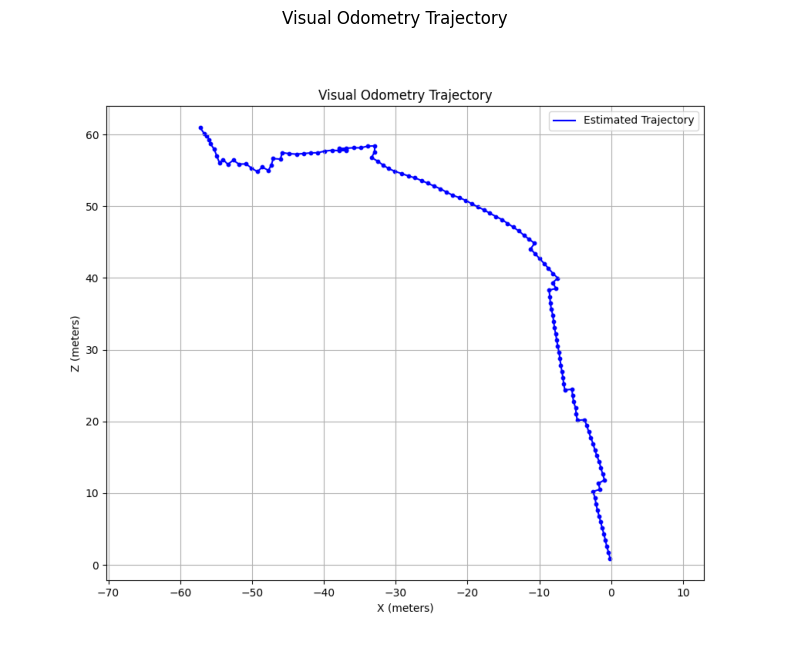

In [34]:
# Open the image using Pillow
image_path = r"C:\Users\YUSSEF\OneDrive\Desktop\Projects\Computer Vision\VisualOdometry\data\trajectory.png"
img = Image.open(image_path)

# Convert the Pillow Image object to a NumPy array (required by imshow)
img_array = np.array(img)

# Display the image using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img_array)
plt.title(f"Visual Odometry Trajectory")
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

## Trying Bundle Adjustment